# Assignment 1A - Question 2

## Classification

In [106]:
import pandas
import numpy
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from scipy.stats import norm
from sklearn import tree

### Import files
Files imported using pandas.read_csv

Check values using .head()

In [107]:
train = pandas.read_csv('CAB420_Assessment_1A_Data/Data/Q2/training.csv')
test = pandas.read_csv('CAB420_Assessment_1A_Data/Data/Q2/testing.csv')
train.head()

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,d,39,36,57,91,59,101,93,27,60,...,-2.36,-18.41,-1.88,-6.43,-21.03,-1.60,-6.18,-22.50,-5.20,-7.86
1,h,84,30,57,112,51,98,92,26,62,...,-2.26,-16.27,-1.95,-6.25,-18.79,-1.99,-6.18,-23.41,-8.87,-10.83
2,s,53,25,49,99,51,93,84,26,58,...,-1.46,-15.92,-1.79,-4.64,-17.73,-0.48,-4.69,-19.97,-4.10,-7.07
3,s,59,26,49,103,47,92,82,25,56,...,2.68,-13.77,-2.53,-6.34,-22.03,-2.34,-6.60,-27.10,-7.99,-10.81
4,d,57,49,66,103,64,106,114,28,59,...,-2.94,-21.74,-1.64,-4.62,-23.74,-0.85,-5.50,-22.83,-2.74,-5.84


In [108]:
test.head()

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,d,67,51,68,115,69,111,136,31,67,...,-9.17,-18.27,-1.80,-6.32,-20.88,-1.63,-6.13,-22.56,-5.53,-8.11
1,s,67,28,51,99,50,97,82,26,59,...,-2.25,-20.13,-2.11,-6.35,-21.94,-1.22,-6.13,-22.20,-3.41,-6.57
2,s,63,26,50,95,49,91,81,26,57,...,-0.44,-17.64,-1.81,-4.70,-19.39,-0.65,-5.01,-20.89,-3.96,-6.85
3,d,63,42,63,97,66,108,111,28,59,...,-2.34,-20.20,-1.89,-5.47,-21.65,-0.99,-5.71,-22.19,-3.41,-6.52
4,s,46,27,50,83,51,90,76,26,56,...,1.25,-18.62,-2.17,-7.11,-21.12,-1.56,-6.35,-22.19,-4.45,-7.32


### Plot data for train and test to Box Plot and standardised Box Plot

Code taken from Week 3 Example 1

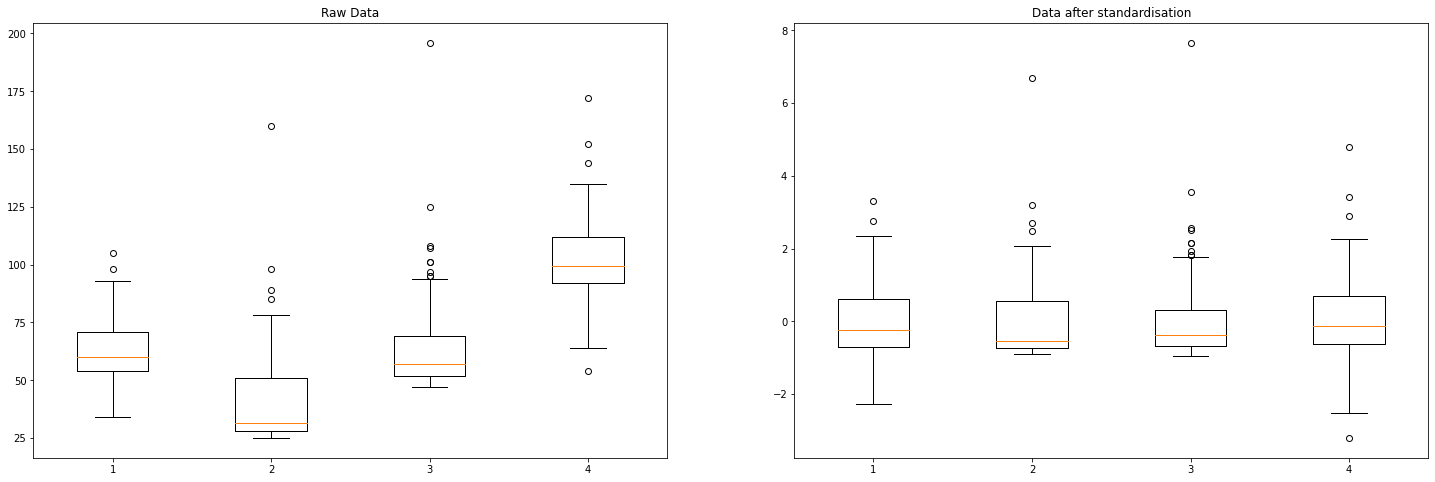

In [109]:
# get the data, we'll just grab 2 dimensions
X = train.iloc[:, 1:5].to_numpy()
train.iloc[:, 0] = train.iloc[:, 0].astype("category")
Y = train.iloc[:, 0].cat.codes.to_numpy()

# plot box plot for the data
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 2, 1)
ax.boxplot(X)
ax.set_title('Raw Data')

# standardise data
mu = numpy.mean(X, 0)
sigma = numpy.std(X, 0)
X = (X - mu) / sigma

# box plot after standardisation
ax = fig.add_subplot(1, 2, 2)
ax.boxplot(X)
ax.set_title('Data after standardisation');

X_train = X
Y_train = Y

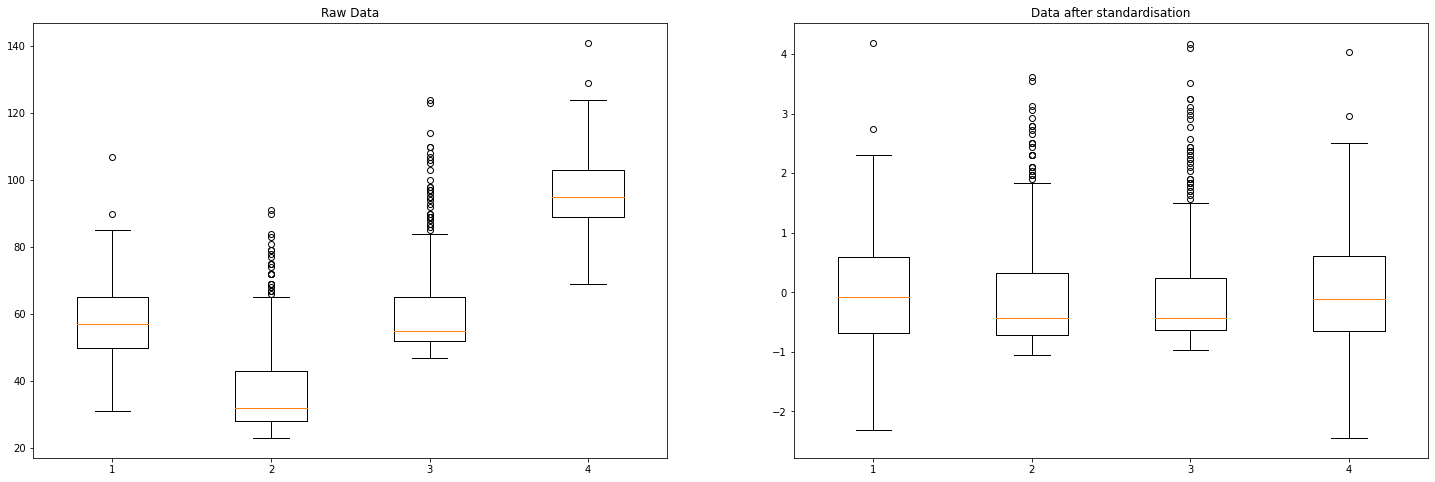

In [110]:
# get the data, we'll just grab 2 dimensions
X = test.iloc[:, 1:5].to_numpy()
test.iloc[:, 0] = test.iloc[:, 0].astype("category")
Y = test.iloc[:, 0].cat.codes.to_numpy()

# plot box plot for the data
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 2, 1)
ax.boxplot(X)
ax.set_title('Raw Data')

# standardise data
mu = numpy.mean(X, 0)
sigma = numpy.std(X, 0)
X = (X - mu) / sigma

# box plot after standardisation
ax = fig.add_subplot(1, 2, 2)
ax.boxplot(X)
ax.set_title('Data after standardisation');

### Split test data into testing and validation sets

Split testing set (50%) and validation set (50%)

Code taken from Week 3 Example 1

In [111]:
X_test, X_val, Y_test, Y_val = train_test_split(X, Y, test_size=0.5, random_state=0)

### Check train and test data to confirm size

In [112]:
X_train.shape

(198, 4)

In [113]:
X_test.shape

(162, 4)

### Evaluate models using confusion matrix

Code taken from Week 3 Example 2

In [114]:
# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - compute the overall classification accuracy on the testing data
# this has simply been created as we're going to do this for each test that we run
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = plot_confusion_matrix(model, X_train, Y_train, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = plot_confusion_matrix(model, X_test, Y_test, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));

### Evaluate basic SVC model

Code taken from Week 3 Example 2

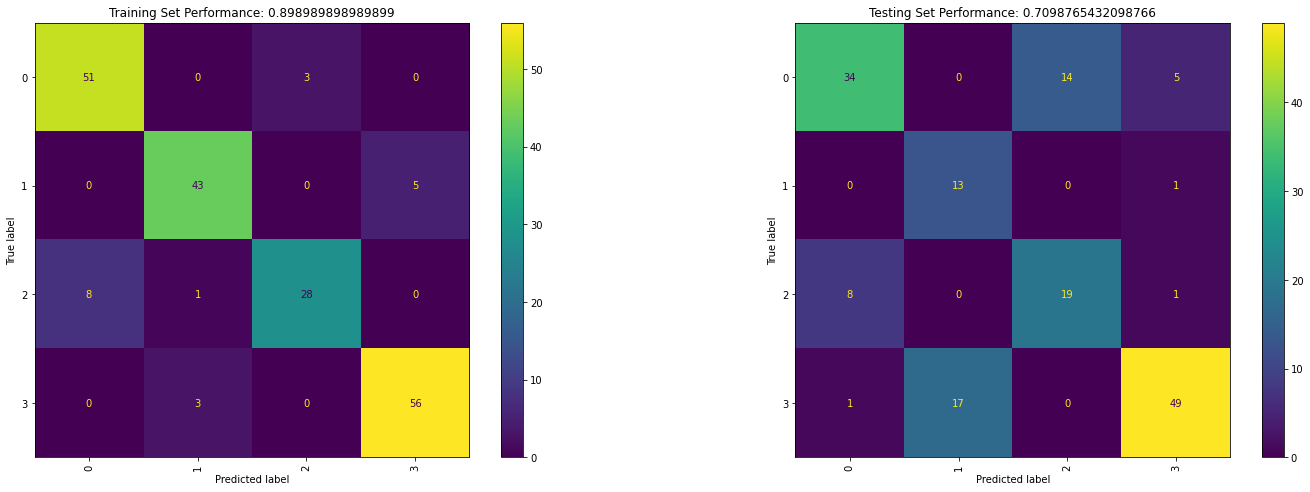

In [130]:
svm = SVC()
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)

### Set param grid to find best values

Code taken from Week 3 Example 2

## used training data

In [132]:
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear'],'class_weight':['balanced','None']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.12, 0.11, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf'],'class_weight':['balanced','None']},
  {'C': [0.1, 1, 10, 100, 1000], 'degree': [3, 4, 5, 6], 'kernel': ['poly'],'class_weight':['balanced','None']},
 ]
svm = SVC()

grid_search = GridSearchCV(svm, param_grid)
grid_search.fit(X_train, Y_train)
grid_search.cv_results_

rs\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\svm\_base.py", line 173, in fit
    y = self._validate_targets(y)
  File "C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\svm\_base.py", line 555, in _validate_targets
    self.class_weight_ = compute_class_weight(self.class_weight,
  File "C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\utils\class_weight.py", line 63, in compute_class_weight
    raise ValueError("class_weight must be dict, 'balanced', or None,"
ValueError: class_weight must be dict, 'balanced', or None, got: 'None'

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning:

            --, --, --, --, --, --, --, --, --, --],
              mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                     True,  True, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False,  True,  True,
                     True,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  

### Use best values found from param grid as values for SVC

Code taken from Week 3 Example 2

{'C': 10, 'class_weight': 'balanced', 'gamma': 0.12, 'kernel': 'rbf'}


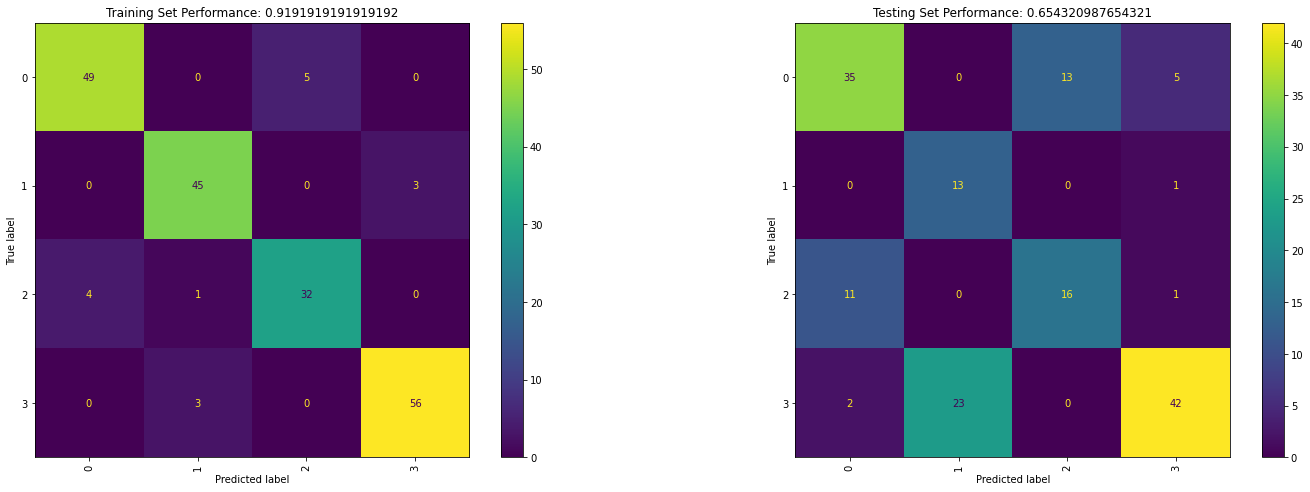

In [135]:
best_system = numpy.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)
svm = SVC().set_params(**params)
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)


### validate using the validation set

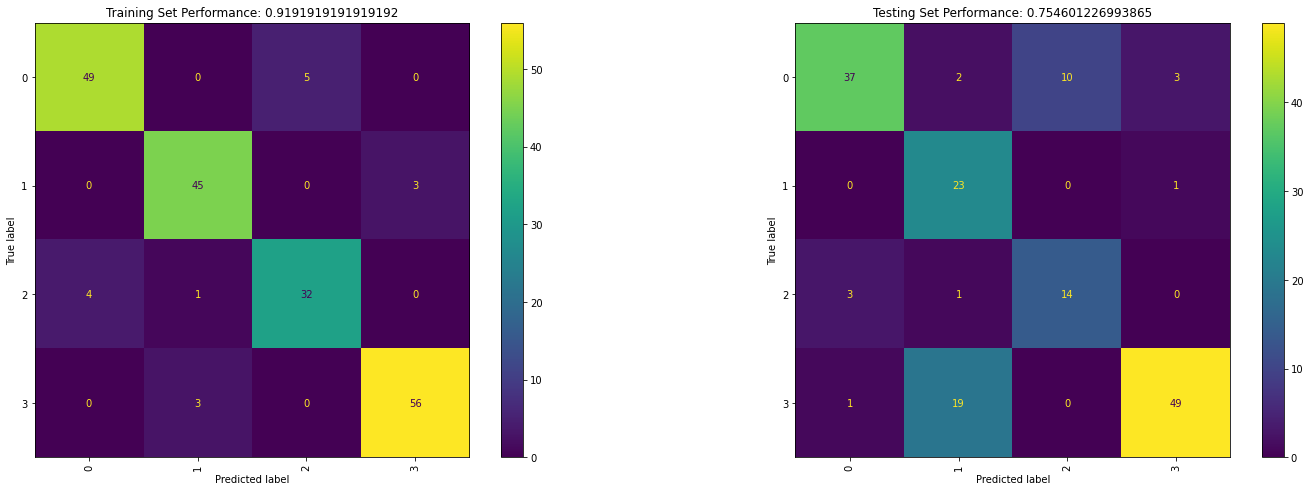

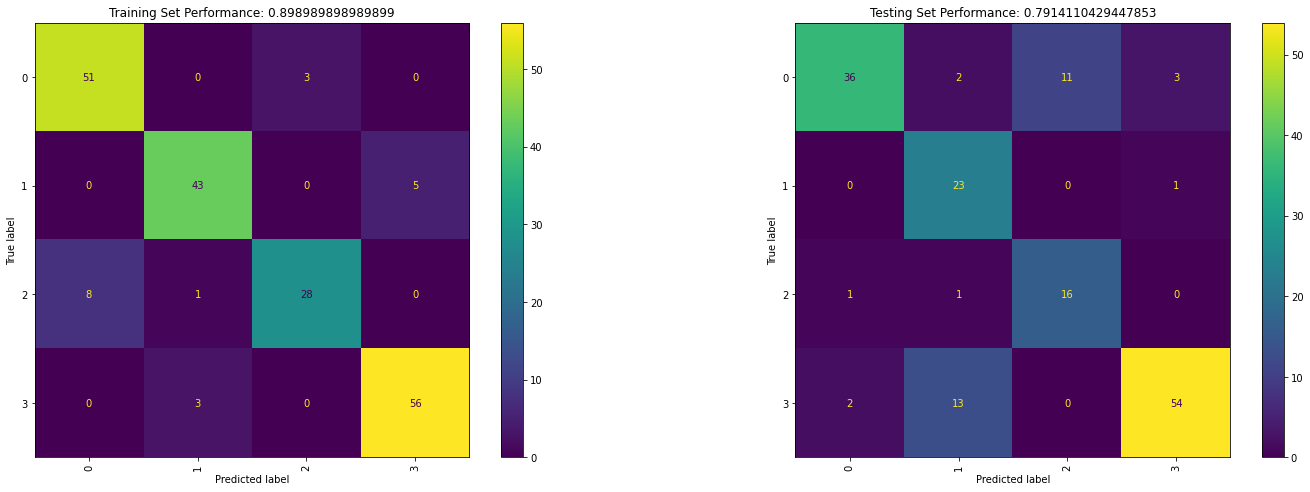

In [136]:
eval_model(svm, X_train, Y_train, X_val, Y_val)

svm2 = SVC()
svm2.fit(X_train, Y_train)
eval_model(svm2, X_train, Y_train, X_val, Y_val)


### Evaluate model using NuSVC

Code taken from Week 3 Example 2

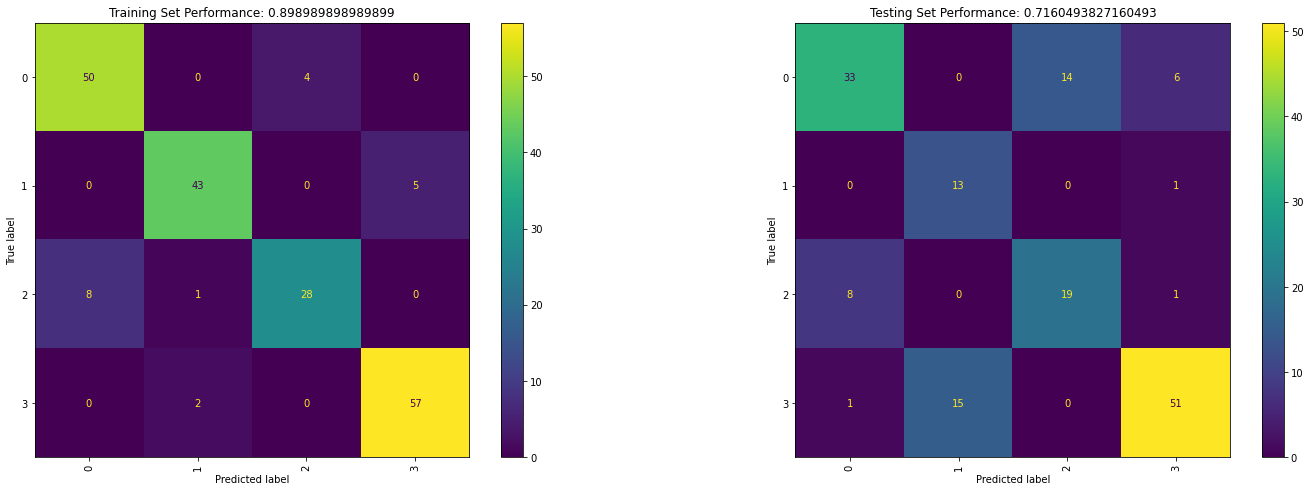

In [148]:
nu_svm = NuSVC()
nu_svm.fit(X_train, Y_train)
eval_model(nu_svm, X_train, Y_train, X_test, Y_test)

In [145]:
param_grid = [
  {'nu':[0.1,0.15,0.2,0.25], 'kernel': ['linear'],'class_weight':['balanced','None']},
  {'nu':[0.1,0.15,0.2,0.25], 'gamma': [0.12, 0.11, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf'],'class_weight':['balanced','None']},
  {'nu':[0.1,0.15,0.2,0.25], 'degree': [3, 4, 5, 6], 'kernel': ['poly'],'class_weight':['balanced','None']},
 ]
svm = NuSVC()

grid_search = GridSearchCV(svm, param_grid)
grid_search.fit(X_train, Y_train)
grid_search.cv_results_

 (most recent call last):
  File "C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\svm\_base.py", line 173, in fit
    y = self._validate_targets(y)
  File "C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\svm\_base.py", line 555, in _validate_targets
    self.class_weight_ = compute_class_weight(self.class_weight,
  File "C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\utils\class_weight.py", line 63, in compute_class_weight
    raise ValueError("class_weight must be dict, 'balanced', or None,"
ValueError: class_weight must be dic

'rbf', 'rbf',
                    'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf',
                    'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf',
                    'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf',
                    'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf',
                    'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf',
                    'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'poly', 'poly',
                    'poly', 'poly', 'poly', 'poly', 'poly', 'poly', 'poly',
                    'poly', 'poly', 'poly', 'poly', 'poly', 'poly', 'poly',
                    'poly', 'poly', 'poly', 'poly', 'poly', 'poly', 'poly',
                    'poly', 'poly', 'poly', 'poly', 'poly', 'poly', 'poly',
                    'poly', 'poly'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False, False, F

{'class_weight': 'balanced', 'gamma': 0.11, 'kernel': 'rbf', 'nu': 0.2}


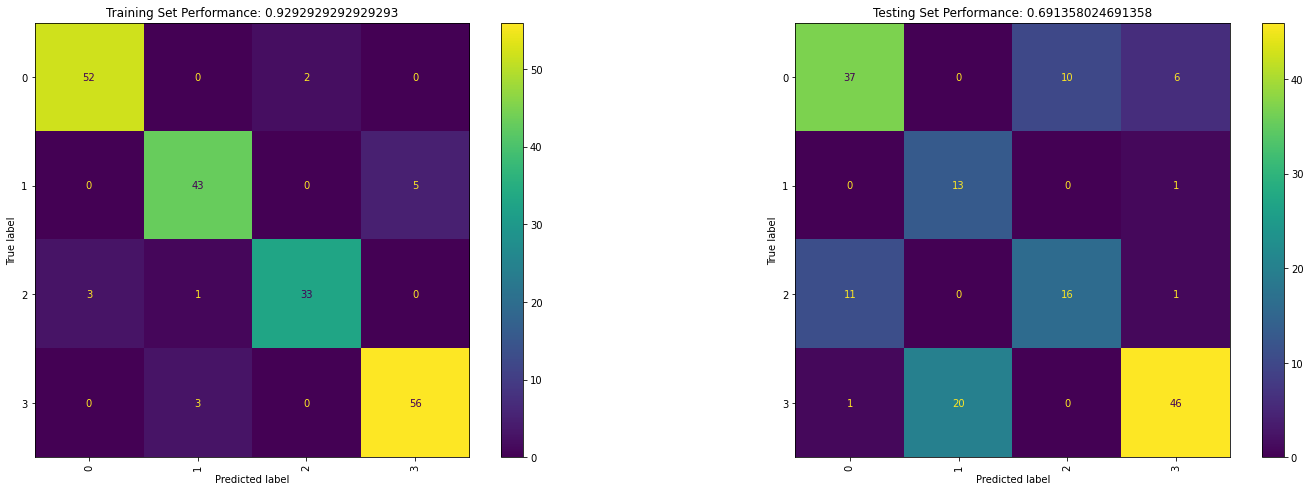

In [146]:
best_system = numpy.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)
svm = NuSVC().set_params(**params)
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)

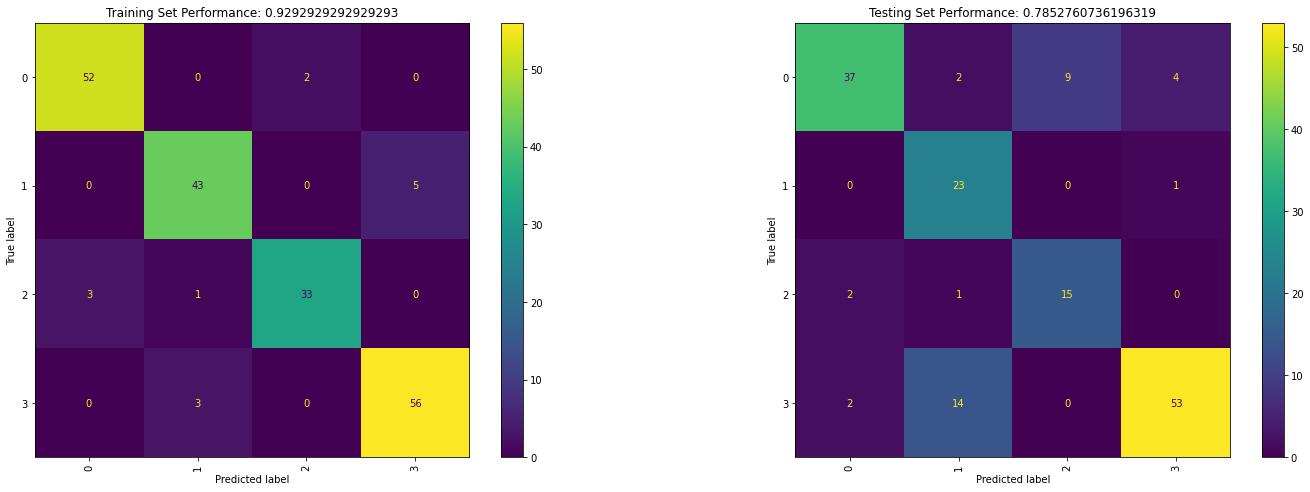

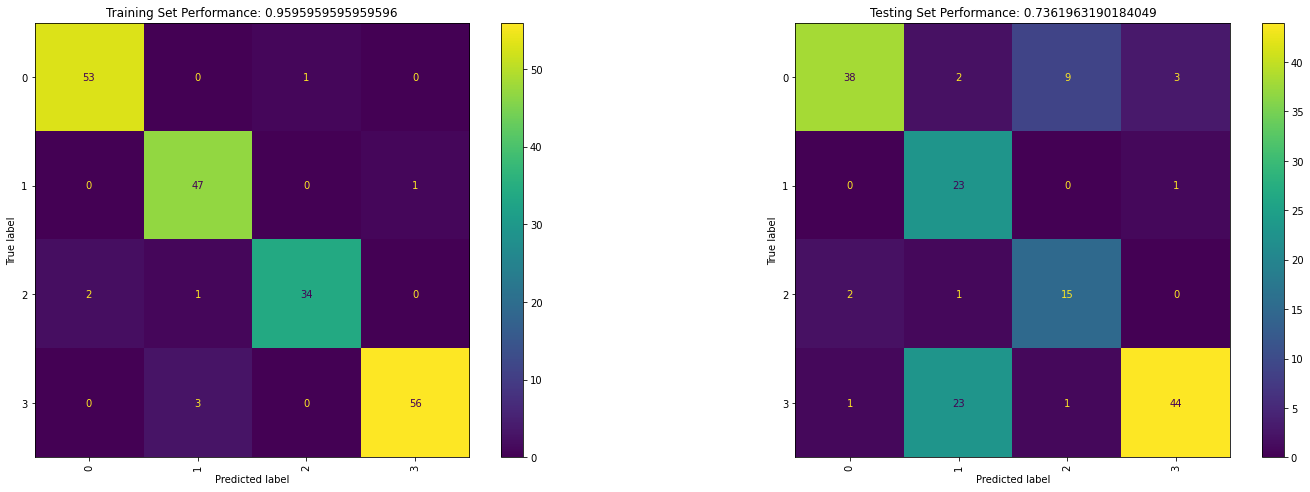

In [147]:
eval_model(svm, X_train, Y_train, X_val, Y_val)

svm2 = NuSVC(nu=0.15)
svm2.fit(X_train, Y_train)
eval_model(svm2, X_train, Y_train, X_val, Y_val)

### Evaluate K Nearest Neighbours model

Code taken from Week 3 Example 2

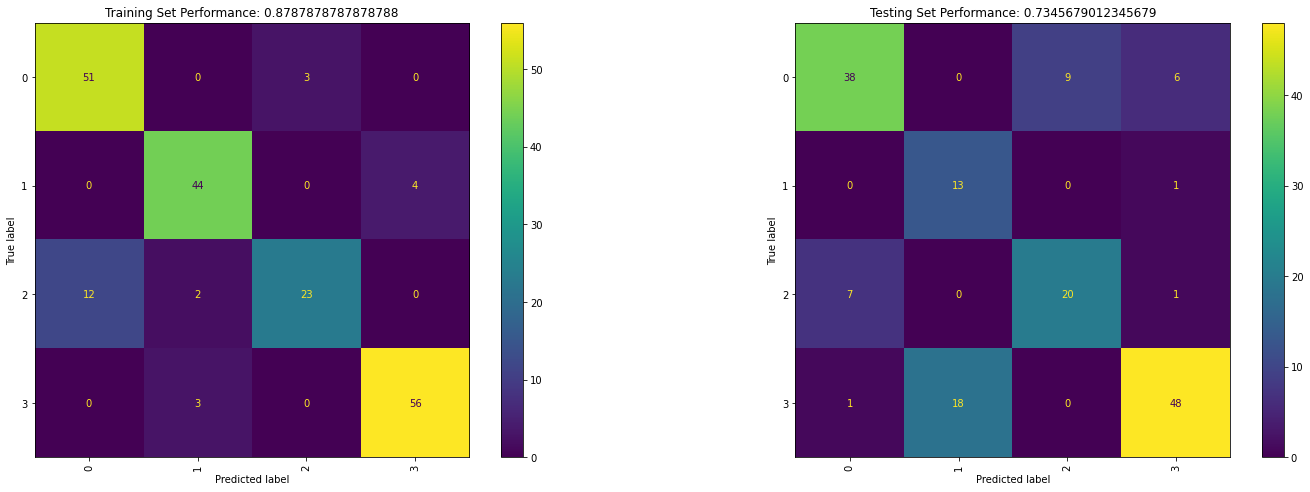

In [121]:
cknn = KNeighborsClassifier(n_neighbors=10)
cknn.fit(X_train, Y_train)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

### Evaluate K Nearest Neighbours using 10 nearest neighbours 

Code taken from Week 3 Example 2

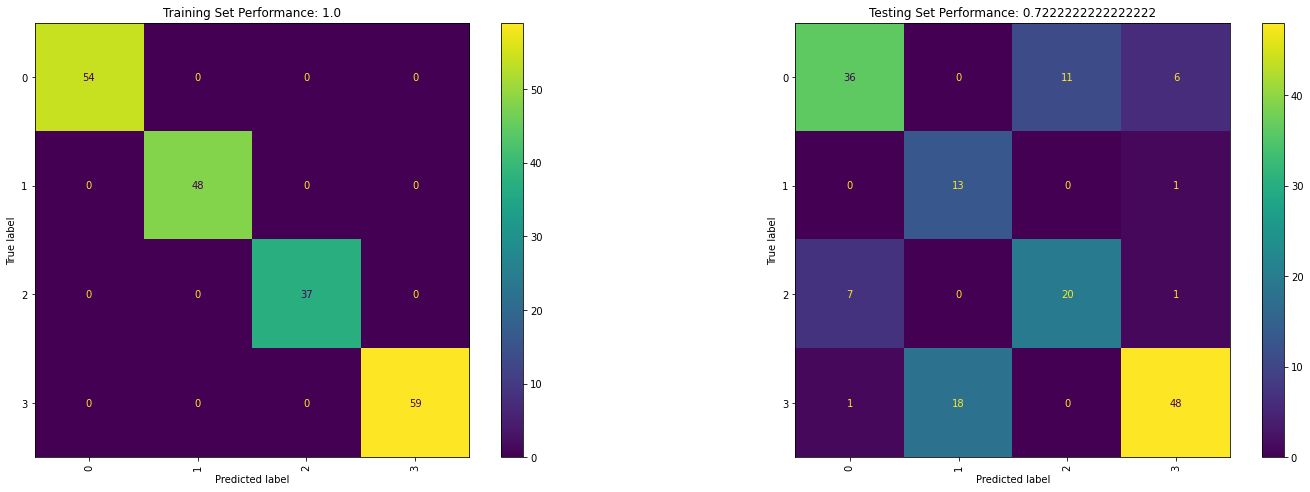

In [122]:
cknn = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn.fit(X_train, Y_train)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

### Find best values for K Nearest Neighbours

Code taken from Week 3 Example 2

In [123]:
cknn = KNeighborsClassifier()
params = {'n_neighbors' : list(range(1,21)), 'weights' : ['uniform', 'distance']}
rand_search = RandomizedSearchCV(cknn, params, n_iter=20)
rand_search.fit(X_val, Y_val)
print(rand_search.cv_results_)

{'mean_fit_time': array([4.93288040e-04, 4.96244431e-04, 2.97594070e-04, 4.96149063e-04,
       5.95092773e-04, 9.92298126e-05, 4.95958328e-04, 1.98316574e-04,
       3.96537781e-04, 3.96776199e-04, 4.95910645e-04, 3.96633148e-04,
       4.93717194e-04, 3.96776199e-04, 2.97498703e-04, 5.02014160e-04,
       4.94480133e-04, 5.93566895e-04, 4.95910645e-04, 3.96823883e-04]), 'std_fit_time': array([5.24954183e-06, 5.76164530e-07, 2.42984603e-04, 2.13248060e-07,
       1.98364315e-04, 1.98459625e-04, 3.13641445e-04, 2.42887219e-04,
       1.98268948e-04, 1.98388121e-04, 2.61174468e-07, 1.98316603e-04,
       4.51209917e-06, 1.98388350e-04, 2.42906689e-04, 1.24568631e-05,
       2.15913003e-05, 1.99470256e-04, 1.50789149e-07, 1.98412027e-04]), 'mean_score_time': array([0.00089288, 0.00128946, 0.00079346, 0.00059519, 0.00059528,
       0.00099187, 0.00148797, 0.00099201, 0.00148821, 0.00069461,
       0.00148816, 0.00139055, 0.00139108, 0.00069461, 0.00100093,
       0.00148187, 0.00148892, 0

### Evaluate K Nearest Neighbours using best values

Code taken from Week 3 Example 2

{'weights': 'uniform', 'n_neighbors': 5}


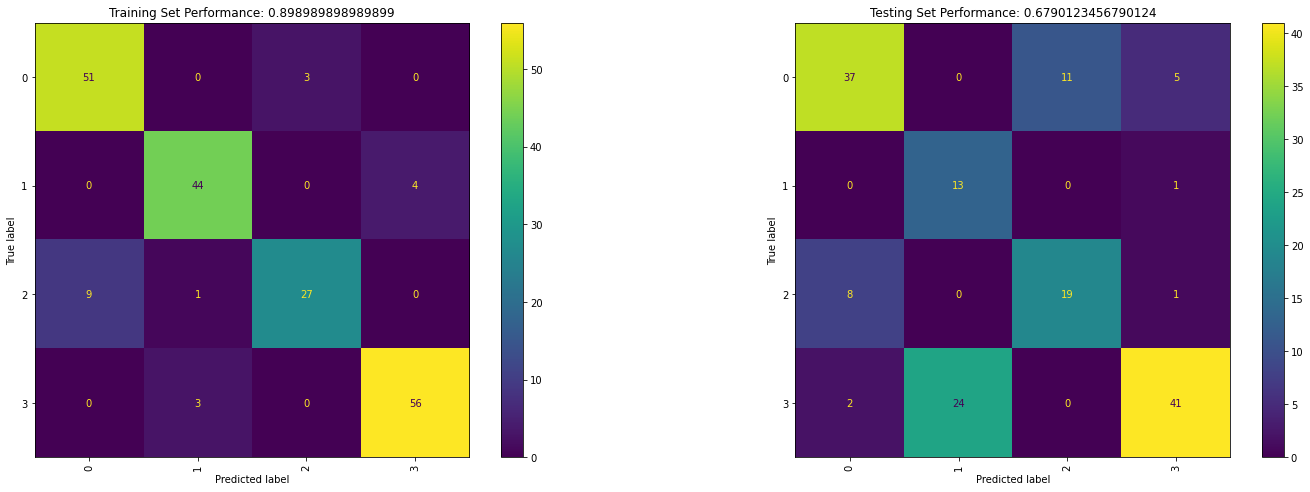

In [124]:
best_system = numpy.argmin(rand_search.cv_results_['rank_test_score'])
params = rand_search.cv_results_['params'][best_system]
print(params)
cknn = KNeighborsClassifier().set_params(**params)
cknn.fit(X_train, Y_train)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

### Evaluate model using Random Forest Classifier

Code taken from Week 3 Example 2

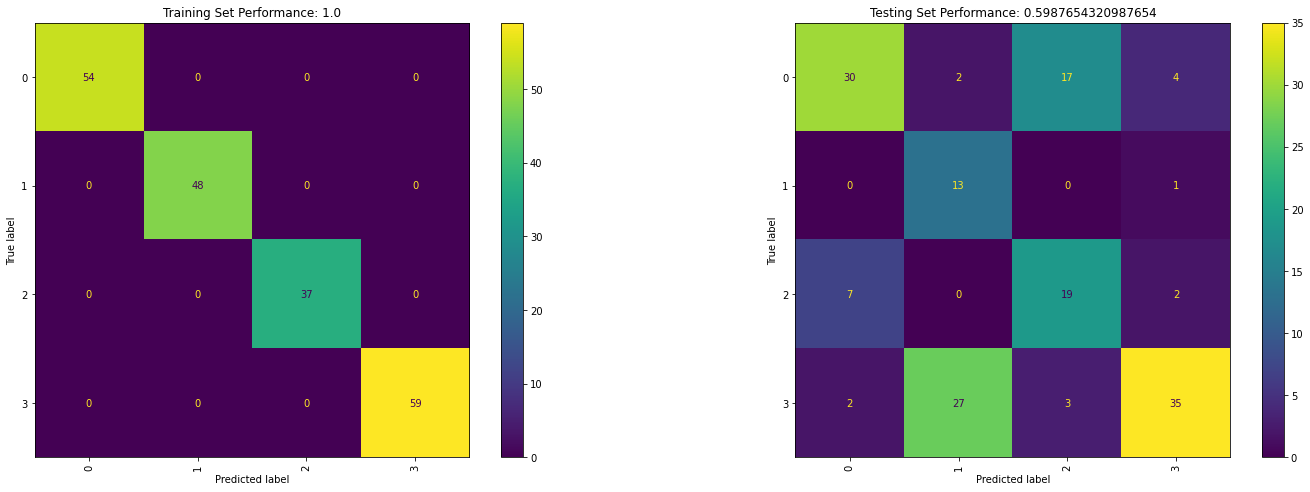

In [125]:
rf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=0)
rf.fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

### Evaluate Random Forest Classifier using 250 estimators, max depth of 2 and a balanced_subsample class weight

Code taken from Week 3 Example 2

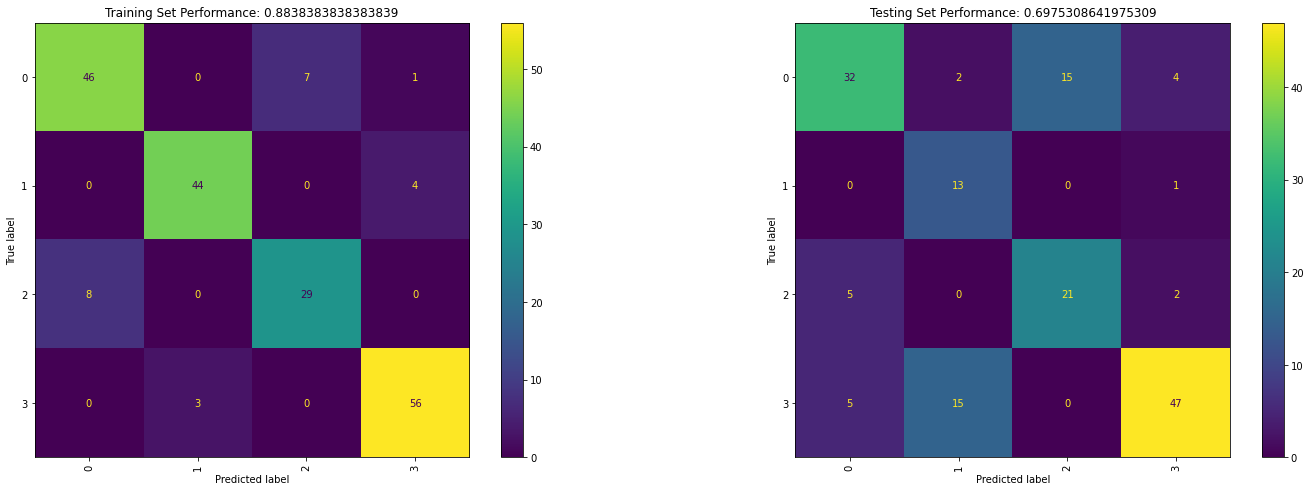

In [126]:
rf = RandomForestClassifier(n_estimators=250, max_depth=2, random_state=0, class_weight='balanced_subsample')
rf.fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

### Evaluate Random Forest Classifier using 250 estimators, max depth of 15 and a balanced_subsample class weight

Code taken from Week 3 Example 2

30
24
27


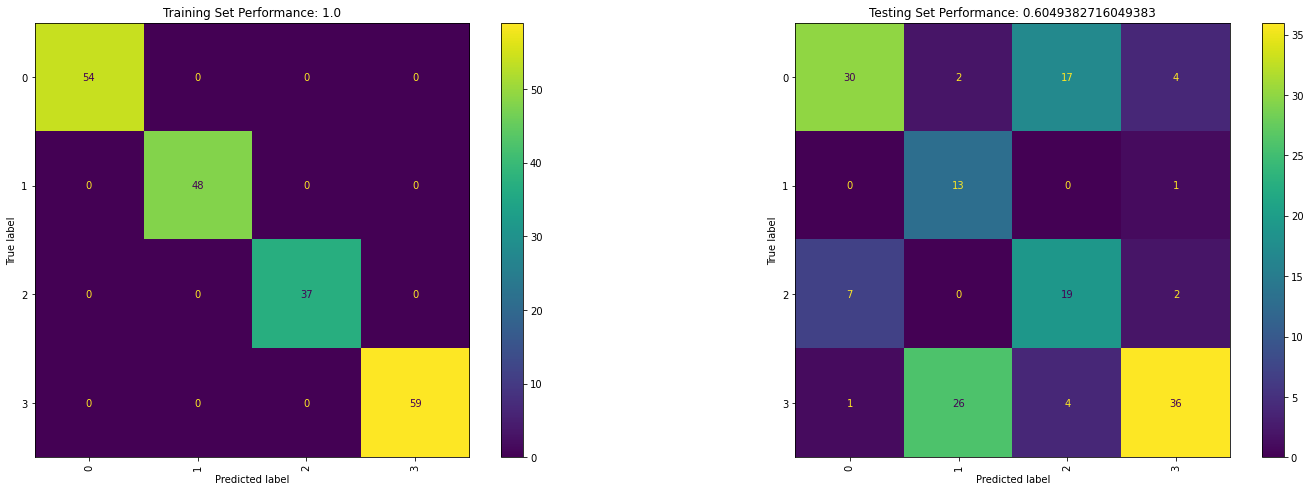

In [127]:
rf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=0, class_weight='balanced_subsample')
rf.fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)
print(rf.estimators_[0].tree_.n_leaves)
print(rf.estimators_[4].tree_.n_leaves)
print(rf.estimators_[42].tree_.n_leaves)

### Evaluate Random Forest Classifier using 250 estimators, max depth of 15 and a balanced class weight

Code taken from Week 3 Example 2

In [128]:
rf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=0, class_weight='balanced')
rf.fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

Error in callback <function flush_figures at 0x18F2D970> (for post_execute):


KeyboardInterrupt: 

In [102]:
rf = RandomForestClassifier()
rf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [103]:
rf = RandomForestClassifier()
params = { 'n_estimators' : [1,10,50,100,250],'max_depth' : list(range(1,21)),'class_weight': ['balanced', 'balanced_subsample', 'None']}
grid_search = GridSearchCV(rf, params)
grid_search.fit(X_val, Y_val)
grid_search.cv_results_

KeyboardInterrupt: 

{'class_weight': 'balanced_subsample', 'max_depth': 18, 'n_estimators': 50}


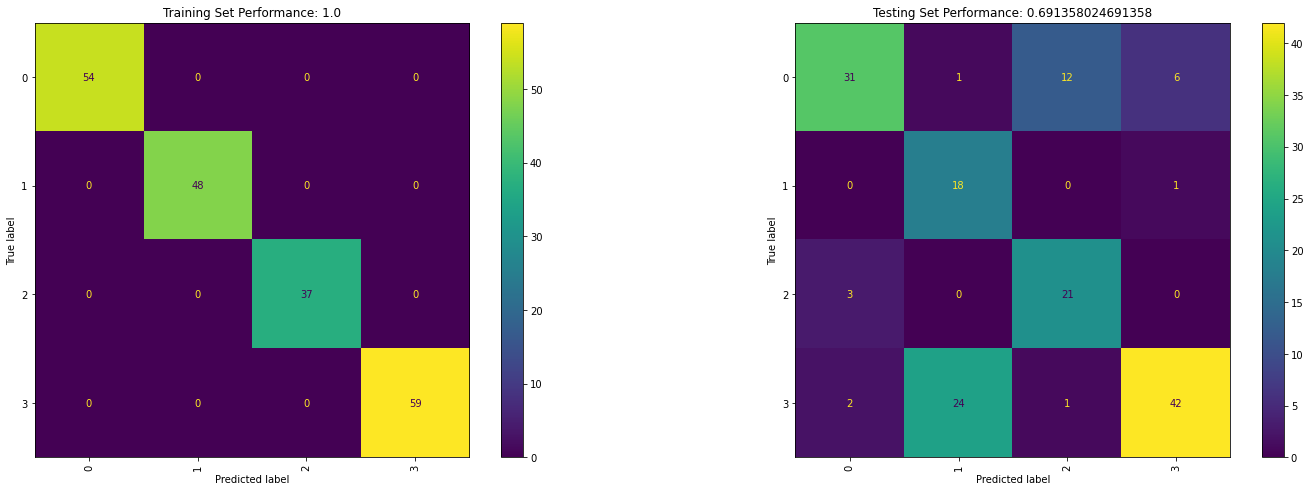

In [25]:
best_system = numpy.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)
rf = RandomForestClassifier().set_params(**params)
rf.fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)